In [1]:
import numpy as np

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tqdm import tqdm_notebook as tqdm

In [4]:
from config import tracker, bokeh_viz
from skimage.draw import polygon

In [5]:
import imageio

In [6]:
cap = imageio.get_reader("~/data/unlabelled/0source/m_demo.mp4")

In [10]:
frames = [x for x in tqdm(cap)]

In [17]:
res = [tracker(frm) for frm in tqdm(frames)]

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.xlim(0,img.shape[1])
plt.ylim(img.shape[0],0)

boxes = []

ver_vecs = []
hor_vecs = []

for hand in hands:
    # hand = hands[0]
    lm = hand['landmarks']
    hw = hand['height_width']

    ver_vec = lm[[0,2]]
    hor_vec = lm[[1,4]]
    
    ver_vecs.append(ver_vec)
    hor_vecs.append(hor_vec)

    plt.scatter(lm[:,0], lm[:,1], c='gray')
    plt.plot(ver_vec[:,0], ver_vec[:,1], c='m')
    plt.plot(hor_vec[:,0], hor_vec[:,1], c='c')

    for j in range(4):
        plt.plot(bbox[[j,(j+1) % 4], 0], bbox[[j,(j+1) % 4], 1], c='#00ff00')
        plt.text(*bbox[j]+np.r_[10,10], str(j), color='#ff00ff')

ValueError: Image size of 162995x300934 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x1080 with 1 Axes>

In [68]:
pts = hor_vecs[0].astype('int')

In [120]:
box = bbox_by_hvec(hor_vecs[1].astype('int'), size=250)

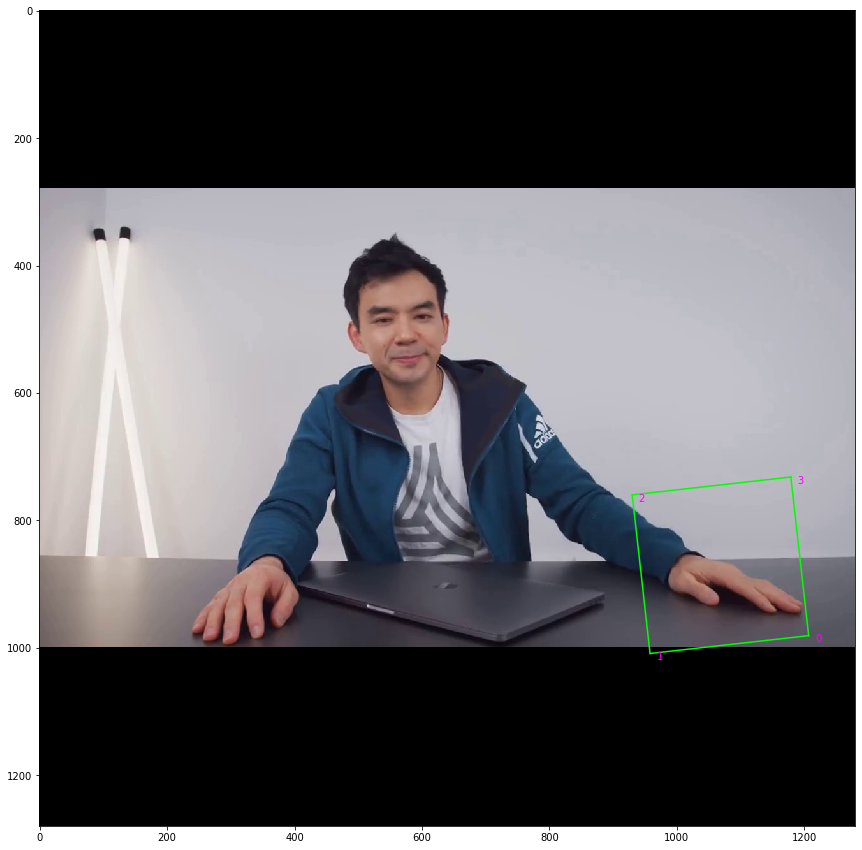

In [121]:
plt.figure(figsize=(15,15))

plt.imshow(img)
for j in range(4):
    plt.plot(box[[j,(j+1) % 4], 0], box[[j,(j+1) % 4], 1], c='#00ff00')
    plt.text(*box[j]+np.r_[10,10], str(j), color='#ff00ff')

In [58]:
hor_vecs[0]

array([[333.94150066, 898.25827026],
       [287.75760269, 910.80330276]])

In [33]:
target = np.r_[[
    [256,256],
    [0,256],
    [0,0],
]].astype('float32')

In [34]:
R = cv2.getAffineTransform(boxes[0][:3].astype('float32'), target)

In [36]:
boxes0 = boxes

In [70]:
def get_mblur(prev, cur):
    flow = cv2.calcOpticalFlowFarneback(prev[:,:,0], cur[:,:,0], None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow


def get_new_bb(frame1, frame2, bboxes):
    flow = get_mblur(frame1, frame2)
    new_boxes = []
    
    for box in bboxes:
        y,x = polygon(box[:,0], box[:,1])
        changes = np.abs(flow[y,x].round() > 3).sum()
        if changes > 1000:
            dydx = flow[y,x].sum(axis=0) / changes
            norm = np.linalg.norm(dydx)
            if norm > 20:
                dydx = dydx / norm * 20
        else:
            dydx = np.r_[0,0]
        new_boxes.append(box + dydx)
    return new_boxes

In [71]:
boxes = boxes0

In [73]:
res = []



for i in tqdm(range(350,450)):
    f0 = tracker.preprocess_img(frames[i])[0]
    f1 = tracker.preprocess_img(frames[i+1])[0]

    new_boxes = get_new_bb(f0, f1, boxes)

    for box in new_boxes:
        box = box.astype('int')
        for j in range(4):
            cv2.line(f1, tuple(box[j]), tuple(box[(j+1) % 4]), color=(0,255,0), thickness=5)
    boxes = new_boxes
    res.append(f1)

In [ ]:
bokeh_viz(res)

In [92]:
img = res[53][300:1000, 300:1000, 0]

In [ ]:
plt.figure(figsize=(15,15))
sob1 = cv2.Sobel(img, cv2.CV_64F, 0, 1)
sob2 = cv2.Sobel(img, cv2.CV_64F, 1, 0)
sob = np.abs(sob1 + sob2)
plt.imshow(sob)

In [ ]:
plt.imshow(flow[:,:,1])

In [ ]:
plt.imshow(frames[1])

In [ ]:
def draw_hand(img, coords):
    img_l = img.copy()
    for b,e in [(0,1), (1,2), (2,3), (3,4),
            (5,6), (6,7), (7,8),
            (9,10),(10,11), (11,12),
            (13,14), (14,15), (15,16),
            (17,18), (18,19), (19,20),
            (0,5), (5,9), (9,13), (13,17), (17,0)
           ]:
        beg = tuple(coords[b])
        end = tuple(coords[e])
        cv2.line(img_l, beg, end, (0,255,0), 2)
    return img_l

In [ ]:
res = []
for frm, crd in zip(frames, coords):
    if not crd is None:
        frm = draw_hand(frm, crd.astype('int'))
    res.append(
        frm
    )

In [ ]:
bokeh_viz(res)

In [ ]:
akaze = cv2.AKAZE_create()

In [ ]:
res0 = akaze.detectAndCompute(frames[127][:,:,0], None)
res1 = akaze.detectAndCompute(frames[128][:,:,0], None)

In [ ]:
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)

In [ ]:
nn_matches = matcher.knnMatch(res0[1], res1[1], 2)

In [ ]:
matched1 = []
matched2 = []
nn_match_ratio = 0.8 # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(res0[0][m.queryIdx])
        matched2.append(res1[0][m.trainIdx])

In [ ]:
pairs = []
for m1, m2 in zip(matched1, matched2):
    pair = np.r_[[m1.pt, m2.pt]]
    pair[1] += np.r_[frames[0].shape[1], 0]
    pairs.append(pair)

In [ ]:
np.c_[pairs].shape

In [ ]:
i = 24

In [ ]:
pair = np.r_[[matched1[i].pt, matched2[i].pt]]

In [ ]:
pair[1] = pair[1] + np.r_[frames[0].shape[1], 0]

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(
    np.concatenate([frames[127], frames[128]],axis=1)
)
for pair in pairs:
    plt.plot(pair[:,0], pair[:,1], alpha=0.3)

In [ ]:
f,ax = plt.subplots(1,2, figsize=(15,15))

ax[0].imshow(frames[127])
ax[1].imshow(frames[128])